# PROJECT - ARTIST ATTESTATION

## 1. Set up and Mounting

#### 1.1 Mounting

In [ ]:
# Quick check on storage. |test| = 23819, # |train| = 79435
!gsutil ls gs://cs6384-mlbucket/
!gsutil du gs://cs6384-mlbucket/test | wc -l
!gsutil du gs://cs6384-mlbucket/train | wc -l
!gsutil du gs://cs6384-mlbucket/info | wc -l

In [2]:
#### Unmount and remove dir if needed
# !sudo fusermount -u /home/jupyter/MOUNT_DIRECTORY
# !rm -r /home/jupyter/MOUNT_DIRECTORY
!mkdir /home/jupyter/MOUNT_DIRECTORY
!gcsfuse --implicit-dirs cs6384-mlbucket /home/jupyter/MOUNT_DIRECTORY
!ls /home/jupyter/MOUNT_DIRECTORY

fusermount: failed to unmount /home/jupyter/MOUNT_DIRECTORY: Invalid argument
2022/05/11 22:16:42.692073 Start gcsfuse/0.41.1 (Go version go1.17.6) for app "" using mount point: /home/jupyter/MOUNT_DIRECTORY
2022/05/11 22:16:42.705744 Opening GCS connection...
2022/05/11 22:16:42.828439 Mounting file system "cs6384-mlbucket"...
2022/05/11 22:16:42.866947 File system has been successfully mounted.
asus  info  oneplus  sample_result  test  test_upload  train


#### 1.2. Setup Library and Variables

In [5]:
!pip install opencv-python
!pip install torch torchvision torchaudio torchsummary

In [7]:
# Load Library
import pandas as pd
import glob
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os
import math
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
import torchvision.transforms as T
import torchvision.models as models
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support
from torch.multiprocessing import Pool, Process, set_start_method
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import defaultdict
import warnings

# custom script 
from processor import *
from helper_func import *
from cmodels import *
from train import *
from evals import *

warnings.filterwarnings('ignore')

In [16]:
# Set up variables 
METADATA_PATH = '/home/jupyter/MOUNT_DIRECTORY/info'
TRAIN_PATH = '/home/jupyter/MOUNT_DIRECTORY/train'
TEST_PATH = '/home/jupyter/MOUNT_DIRECTORY/test'
ASUS_TEST_PATH = '/home/jupyter/MOUNT_DIRECTORY/asus'
ONEPLUS_TEST_PATH = '/home/jupyter/MOUNT_DIRECTORY/oneplus'
MODELS_PATH = '/home/jupyter/artist-attestation/models'
PLOT_PATH = '/home/jupyter/artist-attestation/plot'
OUTPUT_PATH = '/home/jupyter/artist-attestation/output'

# Set up cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

True


In [17]:
class BaselineConvnet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 3, stride = 2, padding = 1)
        nn.init.zeros_(self.conv1.bias) 
        nn.init.normal_(self.conv1.weight, mean = 0, std = (math.sqrt(2/(32*3*3))))
        
        self.pool = nn.MaxPool2d(2)
        self.batch_norm2d = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 32, 3, stride = 2, padding = 1)
        nn.init.zeros_(self.conv2.bias) 
        nn.init.normal_(self.conv2.weight, mean = 0, std = (math.sqrt(2/(32*3*3))))
        
        self.batch_norm1d = nn.BatchNorm1d(228)
        self.fc1 = nn.Linear(6272, 228)
        self.fc2 = nn.Linear(228, 57)

    def forward(self, x):
        
        # Convolution stack 1
        x = self.conv1(x)
        x = self.batch_norm2d(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # Convolution stack 2
        x = self.conv2(x)
        x = self.batch_norm2d(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # Flatten and FC layers
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        x = self.batch_norm1d(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x

# Loads desired pre-built model
def loadPretrainedModels(name,num_classes,pretrained = True, freeze_base = False):
    
    if name == 'resnet-18':
        model = models.resnet18(pretrained)
        in_feat = model.fc.in_features
        model.fc = nn.Linear(in_feat,num_classes)
        if freeze_base == True:
            for param in model.parameters():
                param.requires_grad = False
            model.fc.weight.requires_grad = True
            model.fc.bias.requires_grad = True
        return model

# Unfreeze base layers for training
def unfreeze_base(model):
    m = model
    for param in m.parameters():
        param.requires_grad = True
    return m

def visualize_layer1_filter(model):

    kernels = model.conv1.weight.detach().clone()
    print(kernels.size())
    kernels = kernels - kernels.min()
    kernels = kernels / kernels.max()
    filter_img = make_grid(kernels, nrow = 8)
    plt.imshow(filter_img.cpu().permute(1, 2, 0))

def plot_conf_matrix(y_true,y_pred):
    cf_matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
    plt.figure(figsize=[15,20])
    disp.plot()
    plt.xticks(rotation = 45)
    plt.show()

def predict(model,x,k):
    
    # x is of shape (batch_size,C,H,W)
    # k: top k predicted result 
    
    output = model(x)    # (batchsize, numclass) 
    predicted_1 = torch.topk(output,1,1).indices
    predicted_k = torch.topk(output,k,1).indices
    return predicted_1.to(device), predicted_k.to(device)

def run_test(model, test_loader, k = 3):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    d = {} 
    correct = 0.0
    correct_k = 0.0
    total_size = 0
    acc = 0.0
    y_true = torch.Tensor().to(device)
    y_pred = torch.Tensor().to(device)
    test_samples = 0
    
    with torch.no_grad():
        for i,data in enumerate(test_loader,0):
             
            X, y = data
            pred, pred_k = predict(model, X, k)

            correct += (pred == y).sum().item()

            batch_size = X.size(0)
            for j in range (batch_size):
                if y[j,0] in pred_k[j]:
                    correct_k += 1

            y_true = torch.concat([y_true,y]).to(device)
            y_pred = torch.concat([y_pred,pred]).to(device)

            total_size += 1
            test_samples += X.size(0)
        
        
        d['acc'] = (correct/test_samples) * 100
        d['topk_acc'] = (correct_k/test_samples)*100
        
        p,r,fscore,_ = precision_recall_fscore_support(torch.flatten(y_true.cpu()), torch.flatten(y_pred.cpu()), average = 'weighted')
        d['p'], d['r'], d['fscore'] = p, r, fscore
        d['y_true'] = torch.flatten(y_true.cpu())
        d['y_pred'] = torch.flatten(y_pred.cpu())
        
    return d 

def merge_result(*argv):
    d = defaultdict(list)
    for arg in argv:
        if isinstance(arg, dict):
            for k in arg.keys(): 
                if isinstance(k, list):
                    d[k] += arg[k]
                else:
                    d[k].append(arg[k])
    
    return d    

def save_result(tbl, path):
    f = open(path, 'w')
    for k in tbl:
        values = ' '.join([str(n) for n in tbl[k]])
        f.write(values + "\n")
    f.close()    


def get_model_metrics(path):
    f = open(path, 'r')
    losses, accs, topk_accs = f.readlines()
    losses, accs, topk_accs = losses.strip().split(' '), accs.strip().split(' '), topk_accs.strip().split(' ')
    losses, accs, topk_accs = list(map(float, losses)), list(map(float, accs)), list(map(float, topk_accs))
    
    return {'loss': losses, 'acc': accs, 'topk_acc': topk_accs} 

def find_corrupt_imgs(df, path, transform): 
    invalids = set()
    for i, df in tqdm(df.iterrows()):
        image = df['new_filename']
        img_path = os.path.join(path,image)
        img = cv2.imread(img_path)
        try:
            img = transform(img)
        except TypeError:
            invalids.add(image)
            
    return invalids

def remove_corrupt_imgs(metadata_df, corrupt_list):
    for img in corrupt_list:
        metadata_df = metadata_df[metadata_df['new_filename'] != img]
    return metadata_df

class ImageProcessor(Dataset):

    def __init__(self, path, metadata_df, mode = 'RGB', is_train = True, crop_width = 224, crop_height = 224, is_phone = False):
        self.path = path
        self.mode = mode
        self.metadata_df = metadata_df
        self.X,self.y = self.read_input(self.path)
        self.is_train = is_train
        self.crop_width = crop_width
        self.crop_height = crop_height
        self.transforms = None
        if self.is_train:
            self.transforms = T.Compose([ T.ToTensor(),T.Normalize(mean = [0,0,0], std = [1,1,1]), T.RandomCrop(224), T.RandomHorizontalFlip()])
        else:
            if is_phone: 
                # self.transforms = T.Compose([T.ToTensor(),T.Normalize(mean = [0,0,0], std = [1,1,1]), T.Resize((1456, 992)), T.CenterCrop(224)]) 
                # self.transforms = T.Compose([T.ToTensor(),T.Normalize(mean = [0,0,0], std = [1,1,1]), T.Resize((224, 224))])
                self.transforms = T.Compose([T.ToTensor(),T.Normalize(mean = [0,0,0], std = [1,1,1]), T.Resize((512, 512)), T.CenterCrop(224)]) 
            else:
                self.transforms = T.Compose([T.ToTensor(),T.Normalize(mean = [0,0,0], std = [1,1,1]), T.CenterCrop(224)])
        

    # A simple function to get the file paths of all the training images and their corresponding labels
    def read_input(self,path):

        if os.path.isfile(path):
            _, filename = os.path.split(path)
            label = self.metadata_df[self.metadata_df['new_filename'] == filename, 'artist_idx'].iloc[0]
            return [path],[label]

        elif os.path.isdir(path):
            paths = []
            labels = []
            for i, df in self.metadata_df.iterrows():
                image = df['new_filename']
                img_path = os.path.join(path,image)
                label = df['artist_idx']
                paths.append(img_path)
                labels.append(label)
            return paths,labels

    def __len__(self):
        return len(self.X)

    def __getitem__(self,idx):

        # Fetch image path and label
        path = self.X[idx]
        label = self.y[idx]

        img = cv2.imread(path)

        # Convert to BGR if necessary
        if self.mode == 'BGR':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
        # Preprocess image
        crop = self.transforms(img)
        
        return crop.to(device), torch.Tensor([int(label)]).to(device)

def train(model,train_loader,epochs = 2, lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, k = 3, freeze_base = False):
    
    loss_fn = nn.CrossEntropyLoss().to(device)
    
    if freeze_base == True:
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, betas = (beta_1,beta_2))
    else:
        optimizer = optim.Adam(model.parameters(), lr = lr, betas = (beta_1,beta_2))
    
    epoch_losses = []
    epoch_accuracies = []
    epoch_topk_accs = []
    
    for e in range(epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        correct = 0.0
        correct_k = 0.0
        total_size = 0
        acc = 0.0
        
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs.float().to(device))
            
            loss = loss_fn(outputs, labels.squeeze().type(torch.LongTensor).to(device))
            loss.backward()
            optimizer.step()
            
            batch_size = inputs.size(0)
                
            predicted = torch.topk(outputs,1,1).indices
            predicted_k = torch.topk(outputs,k,1).indices
            correct += (predicted == labels).sum().item()
            total_size += 1

            for j in range (batch_size):
                if labels[j,0] in predicted_k[j]:
                    correct_k += 1

            # print statistics
            running_loss += loss.item()
            print(f'[{e + 1}, {i * batch_size:5d}] batch_loss: {loss.item():.3f}')
        
        epoch_loss = (running_loss/total_size)
        acc = (correct/len(train_dataset)) * 100
        topk_acc = (correct_k/len(train_dataset))*100
        
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(acc)
        epoch_topk_accs.append(topk_acc)
        print(f'[Epoch {e + 1}: epoch_loss: {epoch_loss:.3f} accuracy: {acc:.3f} top-3_accuracy: {topk_acc:.3f}]')

    print('Finished Training')
    
    return {"loss": epoch_losses, "acc": epoch_accuracies, "topk_acc": epoch_topk_accs}

## 2. Data Loading & Preprocessing

In [10]:
# Filter only artists with more than 300 paintings and balance them out

artdf = pd.read_csv(os.path.join(METADATA_PATH, 'all_data_info.csv'))
datadf = artdf.groupby("artist").filter(lambda x: len(x) >= 300)
g = datadf.groupby('artist')
datadf = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))
datadf = datadf.drop(columns=['date'])

# |dataset| = 17214
# Convert artist names into label indexes
artist = datadf[['new_filename','artist','in_train']]
artist['artist'] = artist['artist'].astype('category')
artist['artist_idx'] = artist['artist'].cat.codes
artist.head()

# Split into train and test sets
# train_df = artist[artist['in_train'] == True]
# test_df = artist[artist['in_train'] == False]

train_df = pd.read_csv("/home/jupyter/MOUNT_DIRECTORY/info/" + "train_df.csv")
test_df = pd.read_csv("/home/jupyter/MOUNT_DIRECTORY/info/" + "test_df.csv")

#Get df which contains information of phone images
phone_img_lst = [t.split("/")[-1] for t in glob.glob(ASUS_TEST_PATH + "/*.jpg")]
phone_df = test_df[test_df['new_filename'].isin(phone_img_lst)]

len(datadf)
print(len(train_df))
print(len(test_df))
len(phone_df)

13253
3960


56

In [ ]:
# Check for missing images
# Run only once
train_transform = T.Compose([ T.ToTensor(),T.Normalize(mean = [0,0,0], std = [1,1,1]), T.RandomCrop(224), T.RandomHorizontalFlip()])
test_transform = T.Compose([T.ToTensor(),T.Normalize(mean = [0,0,0], std = [1,1,1]), T.CenterCrop(224)])
phone_transform = T.Compose([T.ToTensor(),T.Normalize(mean = [0,0,0], std = [1,1,1]), T.Resize((512, 512)), T.CenterCrop(224)])

train_corrupt_imgs =  find_corrupt_imgs(train_df, TRAIN_PATH, train_transform)
test_corrupt_imgs =  find_corrupt_imgs(test_df, TEST_PATH, test_transform)

print(f"List of corrupted images in training dataset: {train_corrupt_imgs} ")
print(f"List of corrupted images in testing dataset: {test_corrupt_imgs} ")
      
# Delete corrupted images from dataset
print(len(train_df))
print(len(test_df))
      
train_df = remove_corrupt_imgs(train_df, train_corrupt_imgs)
test_df = remove_corrupt_imgs(test_df, test_corrupt_imgs)
      
print({len(train_df)})
print(len(test_df))

In [11]:
# Create train and test dataset processors
train_dataset = ImageProcessor(TRAIN_PATH,train_df)
test_dataset = ImageProcessor(TEST_PATH,test_df,is_train = False)
asus_dataset = ImageProcessor(ASUS_TEST_PATH,phone_df,is_train = False, is_phone = True)
oneplus_dataset = ImageProcessor(ONEPLUS_TEST_PATH,phone_df,is_train = False, is_phone = True)

print(len(train_dataset), len(test_dataset))
print(len(oneplus_dataset), len(asus_dataset))

13253 3960
56 56


In [12]:
# Create train and test Dataloaders
BATCH_SIZE = 128
train_loader = DataLoader(train_dataset,  batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset,  batch_size = BATCH_SIZE, shuffle = True)
asus_loader = DataLoader(asus_dataset,  batch_size = len(oneplus_dataset), shuffle = True)
oneplus_loader = DataLoader(oneplus_dataset,  batch_size = len(oneplus_dataset), shuffle = True)

In [ ]:
for batch_idx, data in enumerate(train_loader):
    fig = plt.figure(figsize = (14, 7))
    imgs,labels = data
    for i in range(8):
        ax = fig.add_subplot(2, 4, i + 1, xticks = [], yticks = [])     
        plt.imshow(imgs[i].cpu().permute(1, 2, 0))
    break

## 3. Modeling 

#### 3.1. Baseline CNN

In [ ]:
# Load model
baseline_cnn = BaselineConvnet()
baseline_cnn = baseline_cnn.float()
baseline_cnn = baseline_cnn.to(device)
summary(baseline_cnn,(3,224,224))

In [ ]:
# Train Baseline CNN
cnn_train_results = train(baseline_cnn,train_loader,epochs = 18)

In [ ]:
# Save Baseline CNN model and metrics results
torch.save(baseline_cnn.state_dict(), os.path.join(MODELS_PATH , 'baseCNN.pth'))
save_result(cnn_train_results, os.path.join(OUTPUT_PATH, "train_metrics_cnn.txt"))

#### 3.2. Resnet-18 Model

In [ ]:
# Load and Train ResNet-18 from scratch
resnet = loadPretrainedModels('resnet-18',57, False)
resnet.to(device)
resnet_train_result = train(resnet,train_loader,epochs = 18)

In [ ]:
#Save ResNet-18 model and  plot values for ResNet-18 model 
torch.save(resnet.state_dict(), os.path.join(MODELS_PATH, 'ResNet.pth'))
save_result(cnn_train_results, os.path.join(OUTPUT_PATH, "train_metrics_rn.txt"))

#### 3.3. Pre-trained Resnet-18 

In [ ]:
# ResNet-18 Pre-trained model 
resnet_pt = loadPretrainedModels('resnet-18',57, True, freeze_base = True)
resnet_pt.to(device)
resnet_train_result_1 = train(resnet_pt,train_loader,epochs = 5, freeze_base = True)

In [ ]:
# Unfreeze and run for remaining epochs with reduced lr
resnet_pt = unfreeze_base(resnet_pt)
resnet_pt.to(device)
resnet_train_result_2 = train(resnet_pt,train_loader,epochs = 13, lr = 0.0001)

In [ ]:
# Save Pre-trained Resnet-18 Model
torch.save(resnet_pt.state_dict(), os.path.join(MODELS_PATH, 'ResNet_PT.pth'))
save_result(merge(resnet_train_result_1, resnet_train_result_2), os.path.join(OUTPUT_PATH, "train_metrics_rnpt.txt"))

#### 3.4. Save Results & Plotting

In [ ]:
# Read in plot values saved earlier
cnn_metrics = get_model_metrics(os.path.join(OUTPUT_PATH, "train_metrics_cnn.txt"))
rn_metrics = get_model_metrics(os.path.join(OUTPUT_PATH, "train_metrics_rn.txt"))
rnpt_metrics = get_model_metrics(os.path.join(OUTPUT_PATH, "train_metrics_rnpt.txt"))

In [ ]:
# Plot Training Performance Curves
fig, axs = plt.subplots(3,figsize = (10,16))
model_names = ['Baseline CNN', 'Resnet-18', 'Resnet-18 Pretrained'] 
metrics = {'loss': 'Loss', 'acc': 'Accuracy', 'topk_acc': 'Top-3 Accuracy'}

for i, tbl in enumerate([cnn_metrics, rn_metrics, rnpt_metrics]):
    for j, (metric, metric_full_name) in enumerate(metrics.items()): 
        axs[j].plot(tbl[metric], label = model_names[i], linestyle = '-')
        axs[j].set_title(f'Training {metric} vs epochs')
        axs[j].set_xlabel('Epochs')
        axs[j].set_ylabel({metric_full_name})
        axs[j].set_xticks(range(18))
        axs[j].legend()
          
plt.show()
fig.savefig(os.path.join(PLOT_PATH ,'training_plots.pdf'))

## 4. Testing

In [13]:
# Load Model 
# Custom CNN
cnn = BaselineConvnet()
cnn = cnn.float()
cnn = cnn.to(device)
checkpoint = torch.load(os.path.join(MODELS_PATH, 'baseCNN.pth'))
cnn.load_state_dict(checkpoint)

# Resnet 18 
rn = models.resnet18(pretrained = False)
in_feat = rn.fc.in_features
rn.fc = nn.Linear(in_feat,57)
rn.to(device)
checkpoint = torch.load(os.path.join(MODELS_PATH, 'ResNet.pth'))
rn.load_state_dict(checkpoint)

# Pretrained Resnet 18 

pt_rn = models.resnet18(pretrained = True)
in_feat = pt_rn.fc.in_features
pt_rn.fc = nn.Linear(in_feat,57)
pt_rn.to(device)
checkpoint = torch.load(os.path.join(MODELS_PATH, 'ResNet_PT.pth'))
pt_rn.load_state_dict(checkpoint)

<All keys matched successfully>

torch.Size([64, 3, 7, 7])


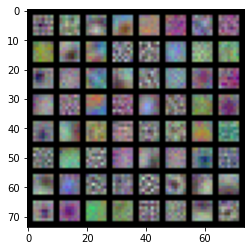

In [21]:
visualize_layer1_filter(rn)
plt.savefig(os.path.join(PLOT_PATH, 'cnn_filter_viz.png'))

In [449]:
# Test Dataset
test_cnn = run_test(cnn, test_loader)
test_rn = run_test(rn, test_loader)
test_rnpt = run_test(pt_rn, test_loader)

In [22]:
# Asus Dataset
asus_cnn = run_test(cnn, asus_loader)
asus_rn = run_test(rn, asus_loader)
asus_rnpt = run_test(pt_rn, asus_loader)

In [23]:
print(asus_cnn['acc'], asus_rn['acc'],  asus_rnpt['acc'])
print(asus_cnn['topk_acc'], asus_rn['topk_acc'],  asus_rnpt['topk_acc'])
print(asus_cnn['p'], asus_rn['p'],  asus_rnpt['p'])
print(asus_cnn['r'], asus_rn['r'],  asus_rnpt['r'])

10.714285714285714 5.357142857142857 30.357142857142854
19.642857142857142 21.428571428571427 50.0
0.038690476190476185 0.03571428571428571 0.22619047619047614
0.10714285714285714 0.05357142857142857 0.30357142857142855


In [24]:
# Oneplus Dataset
oneplus_cnn = run_test(cnn, oneplus_loader)
oneplus_rn = run_test(rn, oneplus_loader)
oneplus_rnpt = run_test(pt_rn, oneplus_loader)

In [25]:
print(oneplus_cnn['acc'], oneplus_rn['acc'],  oneplus_rnpt['acc'])
print(oneplus_cnn['topk_acc'], oneplus_rn['topk_acc'],  oneplus_rnpt['topk_acc'])
print(oneplus_cnn['p'], oneplus_rn['p'],  oneplus_rnpt['p'])
print(oneplus_cnn['r'], oneplus_rn['r'],  oneplus_rnpt['r'])

10.714285714285714 7.142857142857142 42.857142857142854
26.785714285714285 30.357142857142854 58.92857142857143
0.05208333333333333 0.05357142857142857 0.3273809523809524
0.10714285714285714 0.07142857142857142 0.42857142857142855


In [ ]:
save_result(merge_result(test_cnn, test_rn, test_rnpt) , os.path.join(OUTPUT_PATH, "test_metrics")) 

In [ ]:
save_result(merge_result(asus_cnn, asus_rn, asus_rnpt) , os.path.join(OUTPUT_PATH, "test_metrics")) 

In [ ]:
save_result(merge_result(oneplus_cnn, oneplus_rn, oneplus_rnpt) , os.path.join(OUTPUT_PATH, "test_metrics")) 